In [1]:
!pip install torchsummary torchinfo

In [2]:
import utils

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
from torch.utils.data import DataLoader
from torchsummary import summary

seed = 42
AMOUNT_OF_FRAMES = 120

In [33]:
path2data = "/project_ghent/Master-Thesis/featureExtraction/output_blendshape"
SKIP_FRAMES = 5

ids, labels, groups, catgs = utils.get_vids(path2data)
utils.split_dataset(ids, labels, groups, skipframes=SKIP_FRAMES, name="360")

Name		 ids labels groups
--------------------------------------
Train_val: 	 2194 2194 31
Test: 		 243 243 4
Train: 		 1640 1640 23
Validation: 	 554 554 8
--------------------------------------
Name distribution:	 YES - NO
Original distribution:	 0.7271235125153878 - 0.27287648748461224
Train distribution:	 0.7140243902439024 - 0.28597560975609754
Val distribution:	 0.7382671480144405 - 0.26173285198555957
Test distribution:	 0.7901234567901234 - 0.20987654320987653
--------------------------------------
Succesfully saved at /project_ghent/Master-Thesis/ownModelNotebooks/pickled/ with skipframes = 5 [360]


In [4]:
path2data = "/project_ghent/Master-Thesis/featureExtraction/output_blendshape_split"
SKIP_FRAMES = 5

ids, labels, groups, catgs = utils.get_vids(path2data)
utils.split_dataset(ids, labels, groups, skipframes=SKIP_FRAMES, name="120")

Name		 ids labels groups
--------------------------------------
Train_val: 	 6780 6780 31
Test: 		 740 740 4
Train: 		 5069 5069 23
Validation: 	 1711 1711 8
--------------------------------------
Name distribution:	 YES - NO
Original distribution:	 0.7253989361702128 - 0.2746010638297872
Train distribution:	 0.7119747484710989 - 0.2880252515289012
Val distribution:	 0.7375803623611923 - 0.2624196376388077
Test distribution:	 0.7891891891891892 - 0.21081081081081082
--------------------------------------
Succesfully saved at /project_ghent/Master-Thesis/ownModelNotebooks/pickled/ with skipframes = 5 [120]


In [28]:
path2data = "/project_ghent/Master-Thesis/featureExtraction/output_blendshape_after_robot_utterance"

SKIP_FRAMES = 5

ids, labels, groups, catgs = utils.get_vids(path2data)
utils.split_dataset(ids, labels, groups, skipframes=SKIP_FRAMES, name="utterance")

Name		 ids labels groups
--------------------------------------
Train_val: 	 2286 2286 31
Test: 		 238 238 4
Train: 		 1709 1709 23
Validation: 	 577 577 8
--------------------------------------
Name distribution:	 YES - NO
Original distribution:	 0.7274167987321711 - 0.27258320126782887
Train distribution:	 0.7132826214160327 - 0.28671737858396723
Val distribution:	 0.7400346620450606 - 0.25996533795493937
Test distribution:	 0.7983193277310925 - 0.20168067226890757
--------------------------------------
Succesfully saved at /project_ghent/Master-Thesis/ownModelNotebooks/pickled/ with skipframes = 5 [utterance]


In [29]:
yes_count, no_count = labels.count("YES"), labels.count("NO")
print("Weight:", no_count / yes_count)

Weight: 0.3747276688453159


In [34]:
SKIP_FRAMES = 5
train_ds, val_ds, test_ds = utils.get_dataset(skipframes=SKIP_FRAMES, name="360")

Succesfully retrieved at /project_ghent/Master-Thesis/ownModelNotebooks/pickled/ with skipframes = 5 [360]


Epoch 20/20: 100%|██████████| 103/103 [00:25<00:00,  4.08batch/s, Loss=0.439]


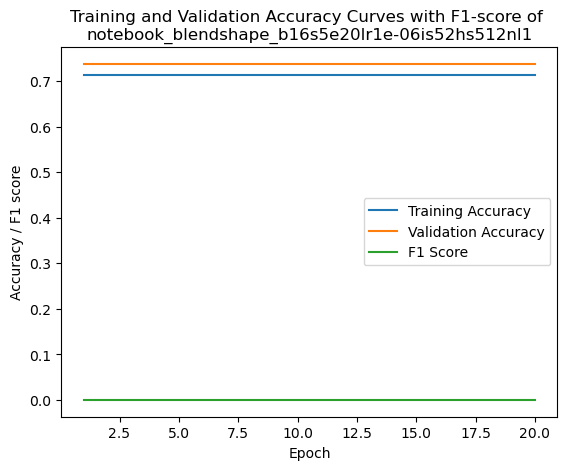

Layer (type:depth-idx)                   Output Shape              Param #
RecipeBlendshapeModel                    [16, 1]                   --
├─LSTM: 1-1                              [16, 72, 512]             1,159,168
├─Linear: 1-2                            [16, 1]                   513
Total params: 1,159,681
Trainable params: 1,159,681
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.34
Input size (MB): 0.24
Forward/backward pass size (MB): 4.72
Params size (MB): 4.64
Estimated Total Size (MB): 9.60

<Figure size 640x480 with 0 Axes>

In [35]:
batch_size = 16
INPUT_SIZE = 52
HIDDEN_SIZE = 512
num_workers = 4
lr = 1e-6
num_epochs = 20
NUM_LAYERS = 1

name = f"notebook_blendshape_b{batch_size}s{SKIP_FRAMES}e{num_epochs}lr{lr}is{INPUT_SIZE}hs{HIDDEN_SIZE}nl{NUM_LAYERS}"

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(seed), num_workers=num_workers)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)  
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = utils.RecipeBlendshapeModel(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)
 
# criterion = nn.BCEWithLogitsLoss(reduction='mean')
# https://discuss.pytorch.org/t/weights-in-bcewithlogitsloss/27452/19
criterion = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=torch.tensor([0.378]).to(device))
optimizer = optim.Adam(model.parameters(), lr=lr)

parameters = {"device": device, 
              "epochs": num_epochs,
              "trainloader": train_dl,
              "valloader": val_dl,
              "testloader": test_dl,
              "criterion": criterion,
              "optimizer": optimizer,
              "batch_size": batch_size,
              "amount_of_frames": AMOUNT_OF_FRAMES // SKIP_FRAMES,
              "categories": utils.categories.keys(),
              "decision": 0.5}

utils.train_and_plot(model, parameters, name)

dummy_input = torch.randn(batch_size, train_ds[0][0].shape[0], train_ds[0][0].shape[1]).to(device)
torchinfo.summary(model, dummy_input.size())

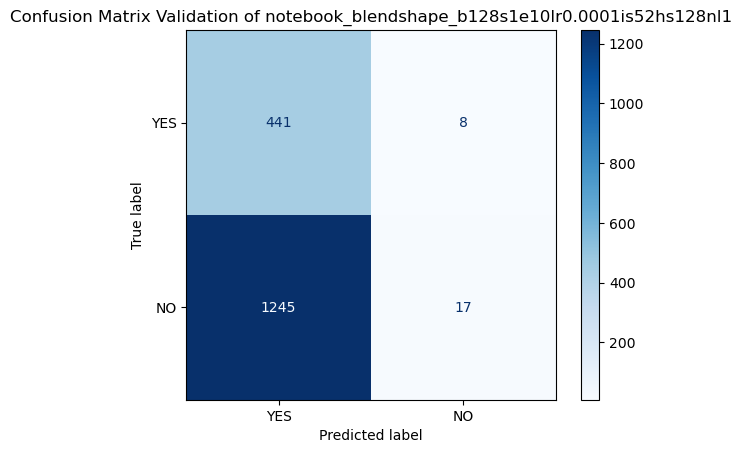

In [41]:
parameters["decision"] = 0.5

utils.plot_confusionmatrix(model, parameters, name, mode="Validation", verbose=False)

In [34]:
dec = 0.5
precision, recall, F1 = utils.calculate_precision_recall(model, parameters, name, dec)
print(f"{dec} -> Precision: {precision}, Recall: {recall}, F1: {F1}")

0.5 -> Precision: 0.7371993871543419, Recall: 0.415902388174699, F1: 0.5317882466895435


In [24]:
utils.show_measures_for_decision_boundaries(model, parameters, name)

0.0 -> Precision: 0.7288039618630572, Recall: 1.0, F1: 0.8431308325759003
0.1 -> Precision: 0.7288039618630572, Recall: 1.0, F1: 0.8431308325759003
0.2 -> Precision: 0.7288039618630572, Recall: 1.0, F1: 0.8431308325759003
0.3 -> Precision: 0.7279447501499551, Recall: 0.993994762008048, F1: 0.8404165925358223
0.4 -> Precision: 0.7320379600373815, Recall: 0.8520445326435673, F1: 0.7874955305916972
0.5 -> Precision: 0.7584659001417546, Recall: 0.3117867768220475, F1: 0.44191365912860736
0.6 -> Precision: 0.8124416433239963, Recall: 0.02253501976386951, F1: 0.04385365315861591
0.7 -> Precision: 1.0, Recall: 0.0005665318860332085, F1: 0.0011324222187710307
0.8 -> Precision: 0, Recall: 0.0, F1: 0
0.9 -> Precision: 0, Recall: 0.0, F1: 0
1.0 -> Precision: 0, Recall: 0.0, F1: 0


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from typing import Dict, Any

def plot_roc_curve(model, parameters: Dict[str, Any], name: str, mode: str = "Validation", verbose: bool = False) -> None:
    """
    Plot the ROC curve

    :param model: The model.
    :param parameters: The parameters for the training loop.
    :param name: The name of the model.
    :param mode: Indicating train, valid, or test mode.
    """
    device = parameters["device"]
    train_loader = parameters["trainloader"]
    val_loader = parameters["valloader"]
    test_loader = parameters["testloader"]
    catgs = parameters["categories"]
    decision = parameters["decision"]
    
    model.eval()
    
    all_labels = []
    all_probs = []

    if mode == "Train":
        loader = train_loader
    elif mode == "Validation":
        loader = val_loader
    elif mode == "Test":
        loader = test_loader
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            val_outputs = model(images)
                
            val_probs = torch.sigmoid(val_outputs)
            
            if verbose:
                print(val_probs, labels)
                
            all_labels.extend(labels.to("cpu").numpy())
            all_probs.extend(val_probs.to("cpu").numpy())
    
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {mode} of {name}')
    plt.legend(loc="lower right")
    plt.savefig(f"/project_ghent/Master-Thesis/ownModelNotebooks/images/roc_curve_{name}.png")
    plt.show()

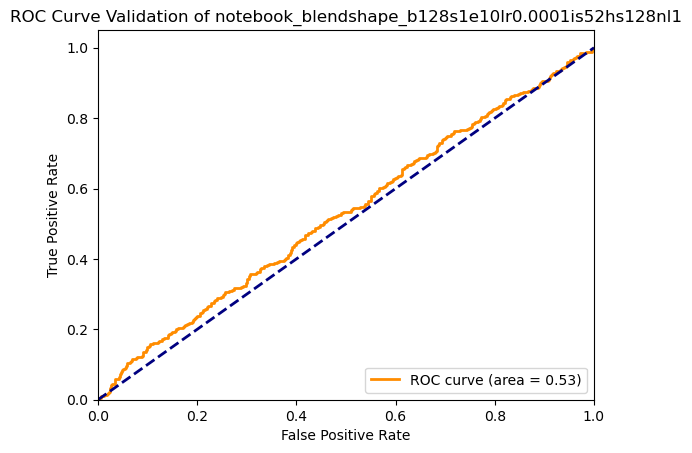

In [44]:
plot_roc_curve(model, parameters, name)